<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_05_Exploratory_Data_Analysis%2C_Training%2C_Evaluating_and_Tuning_Models_(I).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: In-hospital Mortality Prediction (Cont'd)

# 1. Setting up

**Packages for data handling and visualization**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

**Packages for data analysis and modelling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

**Import the immediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/' 
# if you saved the file inside a folder in your Google Drive (instead of the base path), 
# you would need to append the folder name to the above

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,IN_HOSP_DEATH,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


---

# 2. Exploratory Data Analysis (EDA)

The goals of EDA are to:

1. **understand** the data and uncover any problems inherent in the dataset
2. determine if the given dataset is **relevant and sufficient** to answer a specific research question or train a decision support system based on it
3. determine the data **pre-processing or feature engineering** steps required for model training (as discussed in the previous tutorial)
4. **refine** the research problem and/or objectives based on what you have learned about the data

Like many other steps in data analysis, EDA is an iterative process. Here, we will introduce some tools you may use when exploring a dataset. While not demostrated below, one package that may come in handy in EDA is [Pandas Profiling](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/). 

## 2.1. Prediction Target: `IN_HOSP_DEATH`

In [ ]:
df['IN_HOSP_DEATH'].value_counts()

0    53122
1     5854
Name: IN_HOSP_DEATH, dtype: int64

The overall in-hospital death rate is 5854 / (53122 + 5854) = 9.93%

In [ ]:
df['IN_HOSP_DEATH'].mean()

0.09926071622354857

---

## 2.2. Categorical features

We can tally and visualise each feature by category using bar charts. You may also apply statistical tests to see if there are significant differences between groups.

For simple visualizations in Python, the package [seaborn](https://seaborn.pydata.org/) may come in handy.


**`GENDER`**

The average in-hospital mortality rate by gender can be found using

In [ ]:
df[['GENDER', 'IN_HOSP_DEATH']].groupby(['GENDER']).mean()

,IN_HOSP_DEATH
GENDER,
F,0.103742
M,0.095721


And to visualise it, use `sns.barplot()`

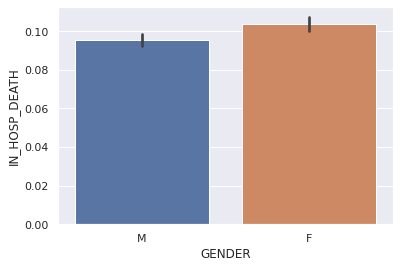

In [ ]:
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', data = df)

**`ADMISSION_TYPE`**

In [ ]:
df[['ADMISSION_TYPE', 'IN_HOSP_DEATH']].groupby(['ADMISSION_TYPE']).mean()

,IN_HOSP_DEATH
ADMISSION_TYPE,
ELECTIVE,0.025564
EMERGENCY,0.129163
NEWBORN,0.007885
URGENT,0.120509


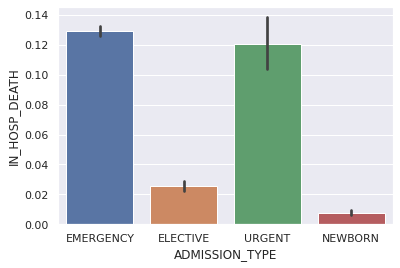

In [ ]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'IN_HOSP_DEATH', data = df)

**`MARITAL_STATUS`**

In [ ]:
df[['MARITAL_STATUS', 'IN_HOSP_DEATH']].groupby(['MARITAL_STATUS']).mean()

,IN_HOSP_DEATH
MARITAL_STATUS,
DIVORCED,0.099284
LIFE PARTNER,0.000000
MARRIED,0.107678
SEPARATED,0.094571
SINGLE,0.082390
UNKNOWN (DEFAULT),0.069321
WIDOWED,0.146027


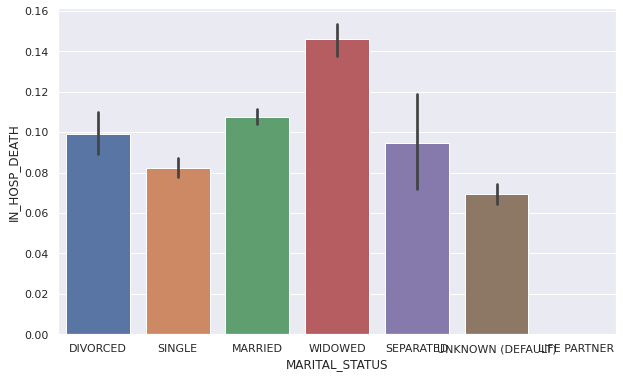

In [ ]:
plt.figure(figsize = (10, 6)) # adjust the size of your plots, formatted as (width, height) in inches
sns.barplot(x = 'MARITAL_STATUS', y = 'IN_HOSP_DEATH', data = df)

**Exercise**: Replicate the above with `INSURANCE`.

It is also possible to visualise more categorical variables within one plot.

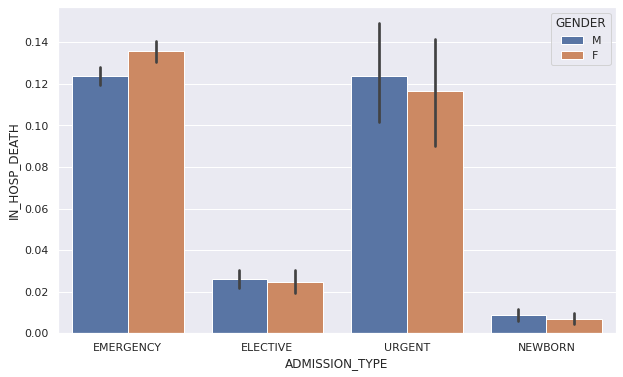

In [ ]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'ADMISSION_TYPE', y = 'IN_HOSP_DEATH', hue = 'GENDER', data = df)

## 2.3. Numerical features

For univariate analysis, we can calculate basic statistics and visualise them using box plots, histograms and density plots. For multivariate, we can use scatter plots (for two numerical features) and side-by-side histograms (for one numerical and one categorical feature).

**`AGE`**

In [ ]:
df['AGE'].describe()

count    58976.000000
mean        54.682990
std         27.111229
min          0.000000
25%         43.000000
50%         61.000000
75%         75.000000
max         90.000000
Name: AGE, dtype: float64

`sns.histplot()` is a good alternative to `Series.hist()` that offers much more flexibility.

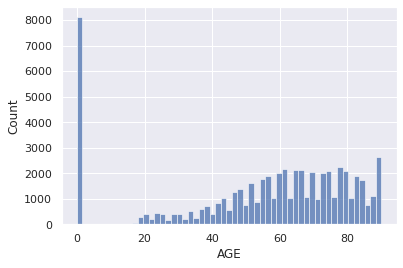

In [ ]:
# histogram
sns.histplot(x = 'AGE', data = df)

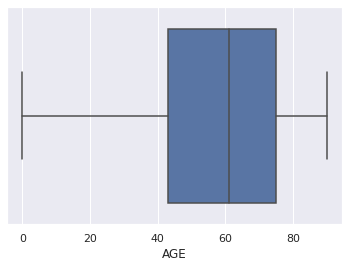

In [ ]:
# box plot
sns.boxplot(x = 'AGE', data = df)

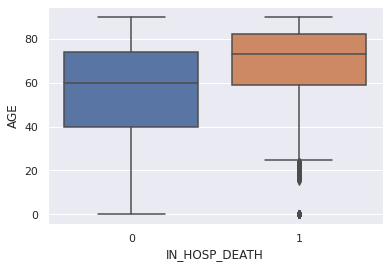

In [ ]:
# box plot by category
sns.boxplot(x = 'IN_HOSP_DEATH', y = 'AGE', data = df) # note that y = 'AGE' instead of x

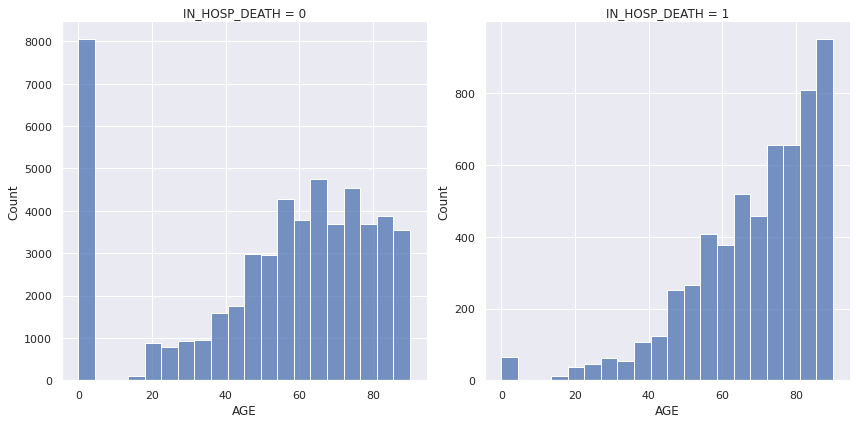

In [ ]:
# side-by-side histrograms
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False, height = 6) # height = 6 specifies the plot size here
g.map(sns.histplot, 'AGE', bins = 20)

**Discussion**: 

* What can you observe from the figure above?
* Based on the figure above, shall we remove the infants (e.g. `AGE` < 1) from our training dataset?

**`DIAG_COUNT`**

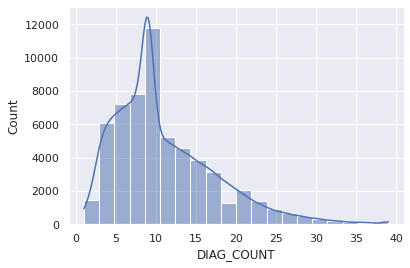

In [ ]:
sns.histplot(x = 'DIAG_COUNT', data = df, bins = 20, kde = True) # kde = True adds a smoothed line representing density

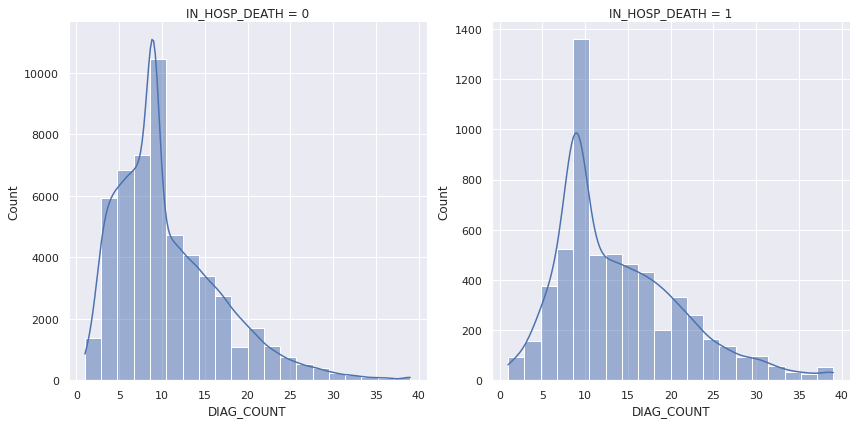

In [ ]:
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False, height = 6)
g.map(sns.histplot, 'DIAG_COUNT', bins = 20, kde = True)

As a reference for you, the following code plots the distributions of all numerical features for the two patient groups using a `For` loop.

AGE


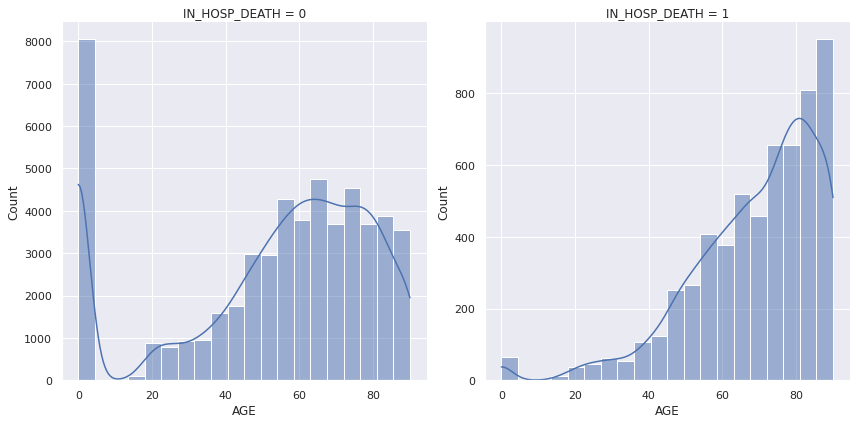

____________________
DIAG_COUNT


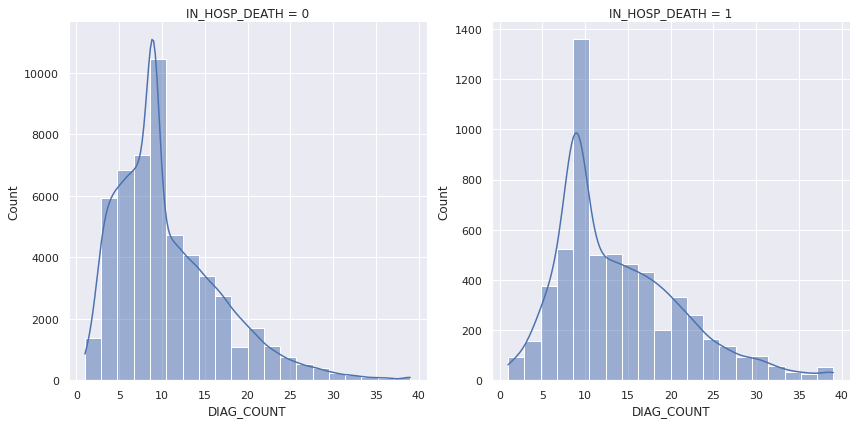

____________________
CALLOUT_COUNT_DAY


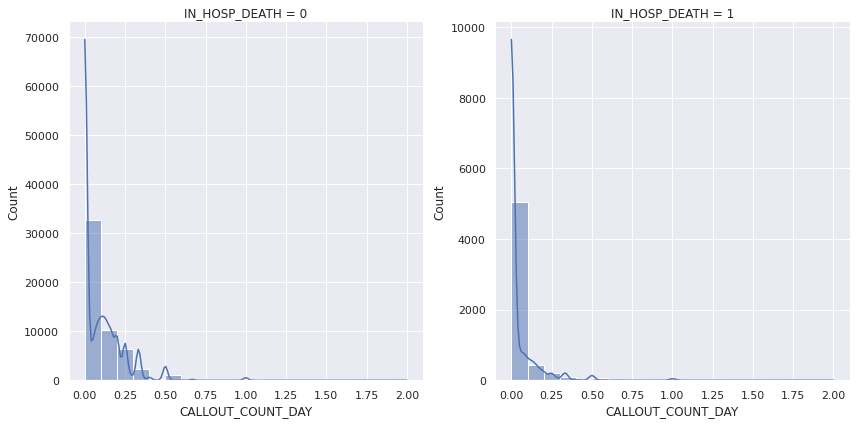

____________________
PRES_COUNT_DAY


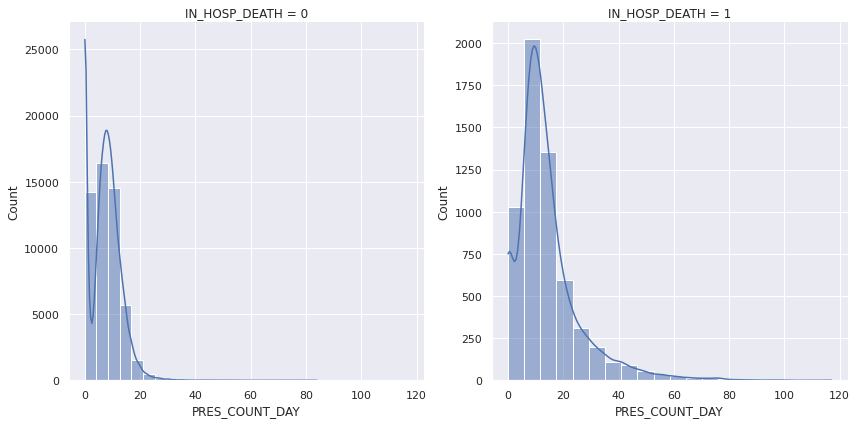

____________________
PROC_COUNT_DAY


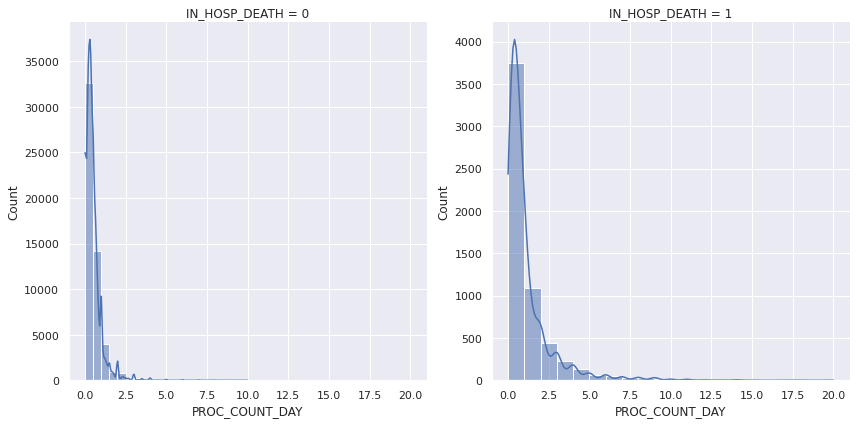

____________________
CPT_COUNT_DAY


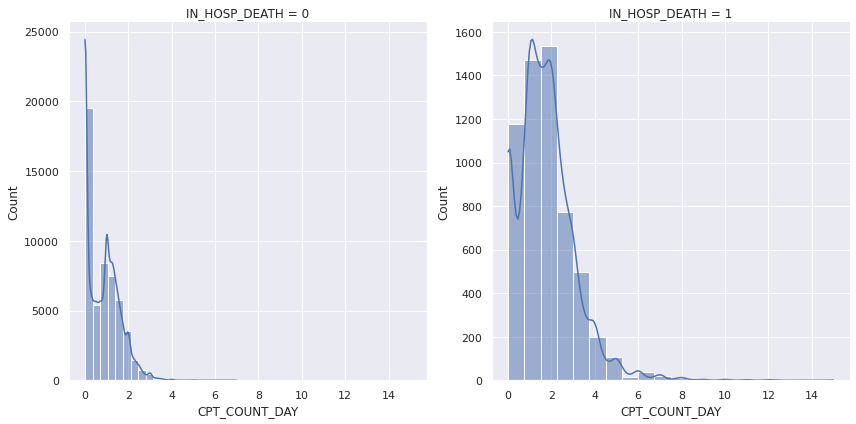

____________________
LAB_COUNT_DAY


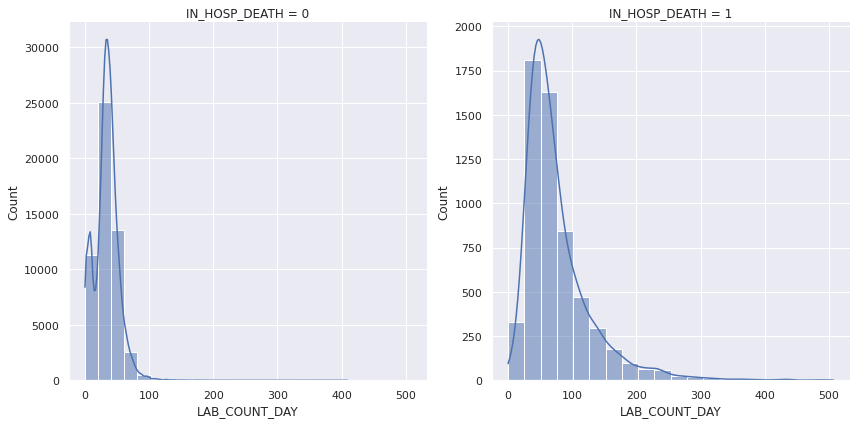

____________________
INPUTS_CV_COUNT_DAY


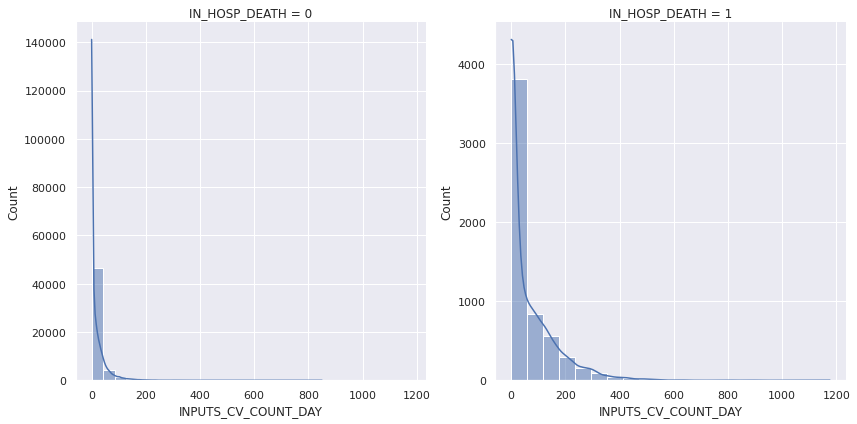

____________________
INPUTS_MV_COUNT_DAY


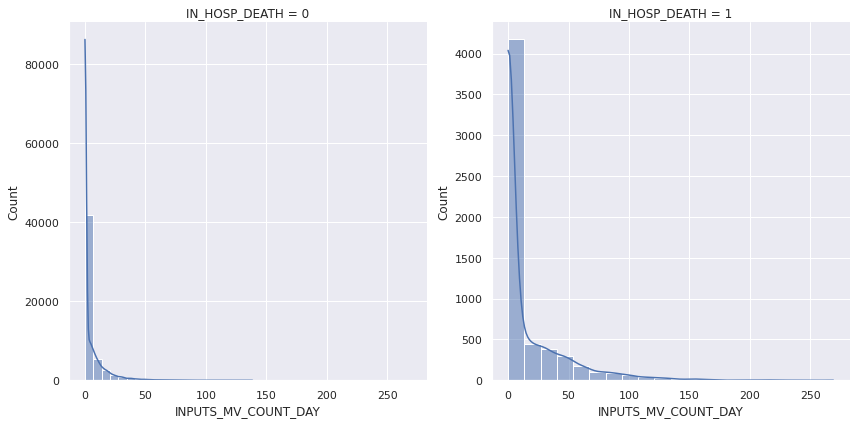

____________________
OUTPUT_COUNT_DAY


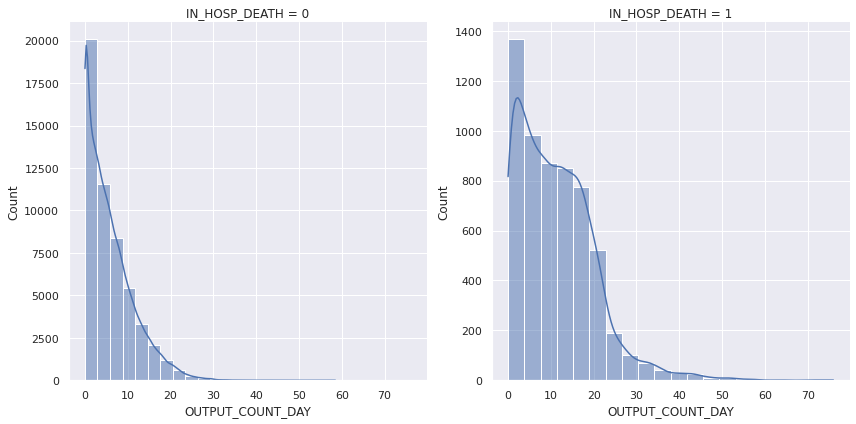

____________________
TRANSFER_COUNT_DAY


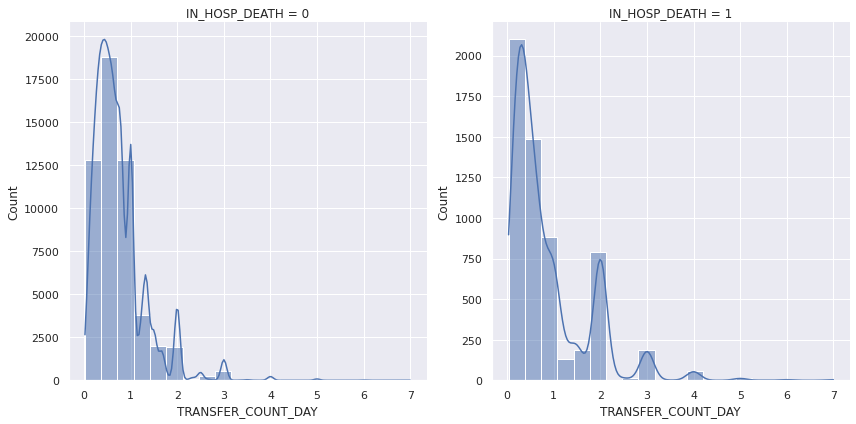

____________________
MICRO_COUNT_DAY


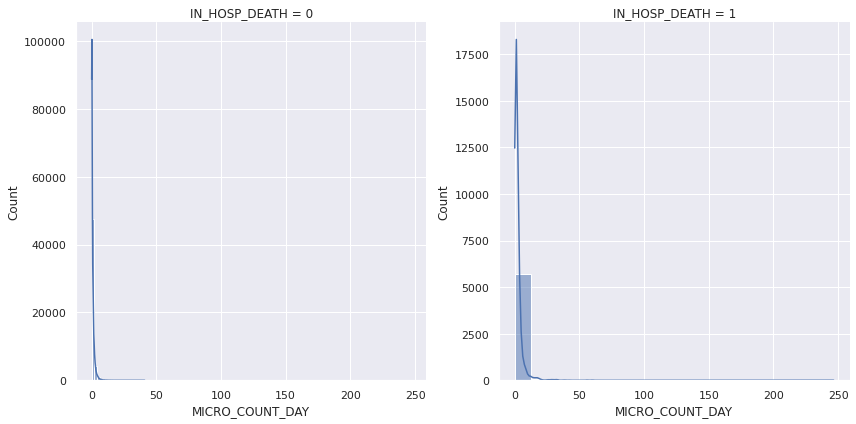

____________________
LOS


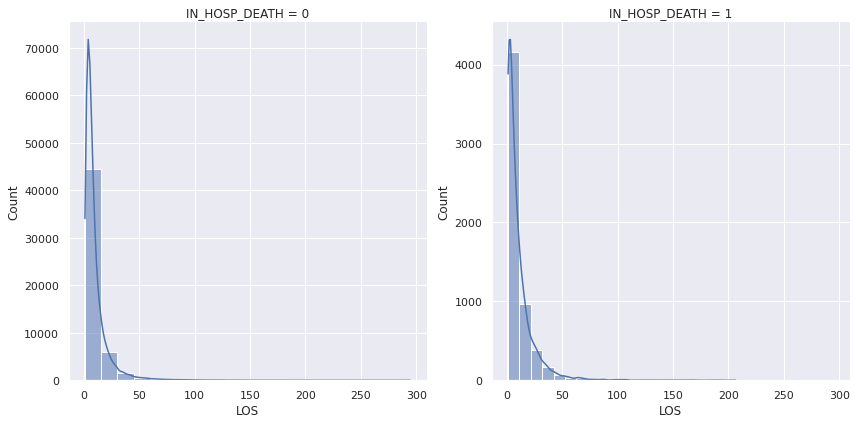

____________________
LOS_ICU


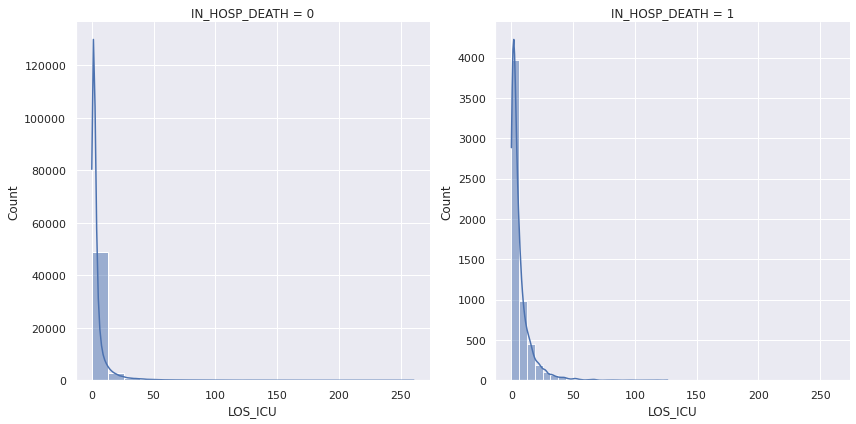

____________________


In [ ]:
numerical_feaures = ['AGE', 'DIAG_COUNT', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 
                     'PROC_COUNT_DAY', 'CPT_COUNT_DAY', 'LAB_COUNT_DAY',
                     'INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 
                     'TRANSFER_COUNT_DAY', 'MICRO_COUNT_DAY', 'LOS', 'LOS_ICU']

for col_name in numerical_feaures:
  print(col_name)
  g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False, height = 6)
  g.map(sns.histplot, col_name, bins = 20, kde = True)
  plt.show()
  print('_'*20)

**Exercise**: Explore the [COVID-19 worldwide dataset](https://github.com/owid/covid-19-data/blob/master/public/data/) by comparing statistics on Jan 1, 2022 across continents. Here are some codes to help you get started.

In [ ]:
df_covid = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df_covid_filtered = df_covid[df_covid['date'] == '2021-12-31'] # filter by date
df_covid_filtered = df_covid_filtered[~df_covid_filtered['iso_code'].str.startswith('OWID_')] # removes non-country locations such as "Worldwide", "Asia" and "Low income"

df_covid_filtered

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
676,AFG,Asia,Afghanistan,2021-12-31,158084.0,28.0,28.143,7356.0,0.0,1.143,3968.427,0.703,0.706,184.660,0.000,0.029,1.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16601.0,NaN,NaN,NaN,NaN,417.0,15588.0,0.039,19.44,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
2116,ALB,Europe,Albania,2021-12-31,210224.0,1325.0,429.000,3217.0,5.0,4.286,73173.975,461.201,149.325,1119.761,1.740,1.492,1.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4485.0,1423366.0,495.440,1.561,3864.0,1.345,0.1110,9.0,tests performed,NaN,NaN,NaN,NaN,NaN,5901.0,NaN,NaN,NaN,NaN,2054.0,2002.0,0.070,46.30,2872934.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.795,NaN,NaN,NaN,NaN
2830,DZA,Africa,Algeria,2021-12-31,218432.0,395.0,333.429,6276.0,5.0,7.714,4895.753,8.853,7.473,140.665,0.112,0.173,1.21,26.0,0.583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22589.0,NaN,NaN,NaN,NaN,506.0,9845.0,0.022,51.85,44616626.0,17.348,29.1,6.211,3.857,13913.839,0.5,278.364,6.73,0.7,30.4,83.741,1.90,76.88,0.748,NaN,NaN,NaN,NaN
3538,AND,Europe,Andorra,2021-12-31,23740.0,618.0,287.143,140.0,0.0,0.143,306900.742,7989.244,3712.062,1809.861,0.000,1.847,1.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1123.0,14.518,0.2557,3.9,people tested,NaN,NaN,NaN,NaN,NaN,650.0,NaN,NaN,NaN,NaN,8403.0,28.0,0.036,59.26,77354.0,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.868,NaN,NaN,NaN,NaN
4228,AGO,Africa,Angola,2021-12-31,81593.0,1722.0,1624.571,1770.0,6.0,3.429,2404.489,50.746,47.875,52.161,0.177,0.101,1.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58842.0,NaN,NaN,NaN,NaN,1734.0,34466.0,0.102,66.67,33933611.0,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,NaN,61.15,0.581,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156922,VNM,Asia,Vietnam,2021-12-31,1731257.0,16515.0,15769.714,32394.0,226.0,232.571,17635.506,168.231,160.639,329.983,2.302,2.369,1.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87782.0,35953000.0,366.236,0.894,90147.0,0.918,0.1749,5.7,samples tested,NaN,NaN,NaN,NaN,NaN,1044164.0,NaN,NaN,NaN,NaN,10636.0,107775.0,0.110,68.52,98168829.0,308.127,32.6,7.150,4.718,6171.884,2.0,245.465,6.00,1.0,45.9,85.847,2.60,75.40,0.704,NaN,NaN,NaN,NaN
15739

---

# 3. Training, Evaluating and Tuning Models

## 3.1. Train-test Split

* Help **mitigate overfitting** (model learns to fit the noise and error terms in the data) while we train machine learning models
* Allow us to report an **unbiased performance metric** using data unseen by the model
* A 70-30 or 80-20 split is usually the most common. 

![](https://miro.medium.com/max/694/1*tBErXYVvTw2jSUYK7thU2A.png)

([Source](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6))

`IN_HOSP_DEATH` would be our prediction target. Here, let's define a list of 38 column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). 

In [ ]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

 Then, create a DataFrame containing input features only as well as a Series containing our prediction target. 

In [ ]:
X = df[features_list]
y = df['IN_HOSP_DEATH']

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split. 

Note that the function outputs four things: the input and output datasets for training and testing respectively. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [ ]:
X_train.shape

(47180, 38)

In [ ]:
X_test.shape

(11796, 38)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively. 

## 3.2. Training a Logistic Regression Model

![](https://static.javatpoint.com/tutorial/machine-learning/images/linear-regression-vs-logistic-regression.png)

([Source](https://www.javatpoint.com/linear-regression-vs-logistic-regression-in-machine-learning))

In this example, we would be utilizing the package package [Scikit-learn](https://scikit-learn.org/stable/user_guide.html) heavily for modelling. In Scikit-learn, the general flow for training and using a model can be simplified into 3 steps:

1. Specify a model to be trained
  * Choose a type of model based on your task and dataset. A full list of available models in the package can be found [here](https://scikit-learn.org/stable/modules/classes.html).
  * Set the hyperparameters of the model. 
  * Assign the model to a variable.
2. Train the model
  * Call the `.fit()` function using your cleaned train dataset.
3. Make predictions
  * Call the `.predict()` function using your cleaned test dataset.

In [ ]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1, 
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [ ]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=1)

In [ ]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([1, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs. 

In [ ]:
y_pred_prob_lr = model_lr.predict_proba(X_test) 
y_pred_prob_lr # the two columns represent the prob of 0 and 1 respectively 

array([[0.31669348, 0.68330652],
       [0.99281121, 0.00718879],
       [0.93265852, 0.06734148],
       ...,
       [0.81834718, 0.18165282],
       [0.98375212, 0.01624788],
       [0.94483697, 0.05516303]])

---

## 3.3. Evaluation (binary classification)

There are several metrics for evaluating the binary classification performances. In general, the most common reported metric for these kind of machine learning problems are

* **F1-score**: harmonic mean of precision and recall
* **Area under receiver operating characteristic curve (AUC)**: overall diagnostic ability across all classification probability cutoffs

![binary classification metrics](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

([Source](https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html))

<img src='https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg' width='40%'>

([Source](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

In [ ]:
# to calculate accuracy:
accuracy_score(y_test, y_pred_lr)

0.9270939301458121

In [ ]:
# to calculate F1 score:
f1_score(y_test, y_pred_lr)

0.49232585596221956

In [ ]:
# to display multiple classification-related metrics:
print(classification_report(y_test, y_pred_lr, digits = 3))

              precision    recall  f1-score   support

           0      0.933     0.990     0.961     10625
           1      0.797     0.356     0.492      1171

    accuracy                          0.927     11796
   macro avg      0.865     0.673     0.727     11796
weighted avg      0.920     0.927     0.914     11796



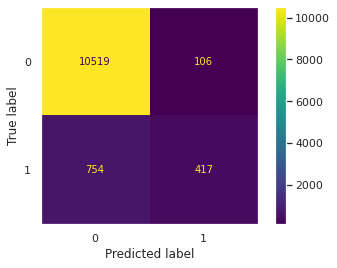

In [ ]:
# to visualise a confusion matrix using a heatmap:
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test)
plt.grid(False) # just to disable grid lines for this plot

Note that the colour in the above plot has little implications as the quantity of the two classes differ by too much. We can express them as ratios and percentages instead. 

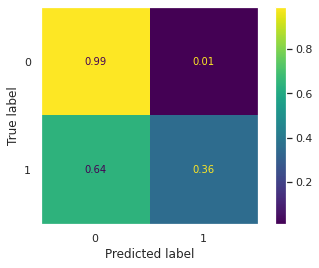

In [ ]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, normalize = 'true') 
plt.grid(False)

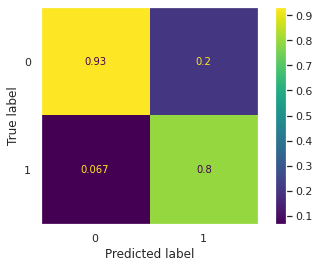

In [ ]:
# precision-related metrics (% of column)
ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test, normalize = 'pred')
plt.grid(False)

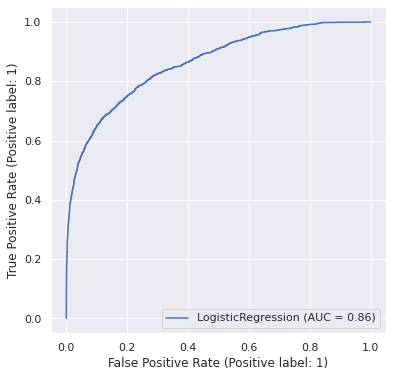

In [ ]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(model_lr, X_test, y_test, ax = ax)

In [ ]:
# to calculate Area under ROC:
roc_auc_score(y_test, y_pred_prob_lr[:,1])

0.8615282664389411

**Some Observations**

* Despite having an accuracy of 92.6%, the overall F1-score is around 48%. The high accuracy is due to class imbalance and the model predicted the majority class (`IN_HOSP_DEATH == 0`) correctly. 
* The recall for the positive examples is 34%, meaning that only around one-third of those who died within their hospital stay is successfully detected by the model.

# References

* [Which machine learning algorithm should I use?](https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/)
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet-2.png)
* [Dramatically Improve Your Exploratory Data Analysis (EDA)](https://towardsdatascience.com/dramatically-improve-your-exploratory-data-analysis-eda-a2fc8c851124)
* [Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
